In [107]:
!pip install esda geopandas libpysal shapely mapclassify

In [108]:
import os
import pandas as pd
pd.set_option('display.max_columns', 500)
import esda
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import libpysal as lps
from esda import Moran
import datetime
import matplotlib.pyplot as plt
from pyproj import CRS
import seaborn as sns
import mapclassify as mc
from matplotlib import colors
import itertools
from esda.moran import Moran_BV
from esda.moran import Moran_Local_BV
from matplotlib import colors

In [109]:
gdf_comunas_shape = gpd.read_file('./DATA/DATASETS/MAPA/limite_catastral_de_comun.geojson', crs=CRS("WGS84"))

/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GeoJSON does not support open option CRS
  return ogr_read(


In [110]:
barrios = gpd.read_file('./DATA/DATASETS/MAPA/barrios_y_veredas.geojson', crs=CRS("WGS84"))

/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GeoJSON does not support open option CRS
  return ogr_read(


In [111]:
to_delete = [
    'SAN CRISTOBAL',
    'ALTAVISTA',
    'SANTA ELENA',
    'SAN ANTONIO DE PRADO',
    'PALMITAS'
]

comunas = gdf_comunas_shape[~gdf_comunas_shape['nombre'].isin(to_delete)].comuna.unique()

In [112]:
gdf_comunas_shape = gdf_comunas_shape[gdf_comunas_shape['comuna'].isin(comunas)]

In [113]:
atractivos_turisticos = gpd.read_file('./DATA/DATASETS/Turismo/atractivos_turisticos.geojson', crs=CRS("WGS84"))
metricas_hoteles = gpd.read_file('./DATA/DATASETS/GEOJSON/metricas_hoteles.geojson', crs=CRS("WGS84"))
metricas_residentes = gpd.read_file('./DATA/DATASETS/GEOJSON/metricas_residentes.geojson', crs=CRS("WGS84"))

/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GeoJSON does not support open option CRS
  return ogr_read(
/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GeoJSON does not support open option CRS
  return ogr_read(
/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GeoJSON does not support open option CRS
  return ogr_read(


In [114]:
hoteles_cols = list(filter(lambda x: '_Min' in x or '_Count' in x, metricas_hoteles.columns)) + ['geometry']
residentes_cols = list(filter(lambda x: '_Min' in x or '_Count' in x, metricas_residentes.columns)) + ['geometry']

In [115]:
# barrios = barrios.rename(columns={'codigo': 'comuna'})
# gdf_comunas = barrios
# gdf_comunas = gdf_comunas[gdf_comunas['limitecomunacorregimientoid'].isin(comunas)]
gdf_comunas = gdf_comunas_shape

In [116]:
metricas_hoteles = metricas_hoteles.to_crs(gdf_comunas.crs)
metricas_residentes = metricas_residentes.to_crs(gdf_comunas.crs)

In [117]:
gdf_hoteles = metricas_hoteles[hoteles_cols]
gdf_residentes = metricas_residentes[residentes_cols]

gdf_hoteles = gdf_hoteles.apply(lambda x: x.astype('float64') if x.name != 'geometry' else x)
gdf_residentes = gdf_residentes.apply(lambda x: x.astype('float64') if x.name != 'geometry' else x)

In [118]:
def load_geodf(filename, latitude='latitud', longitude='longitud', time_variable=None, min_date=None):
    df = pd.read_csv(filename)
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[longitude], df[latitude]), crs=CRS("WGS84"))
    if time_variable:
        gdf[time_variable] = pd.to_datetime(gdf[time_variable])

        if min_date:
            gdf = gdf[(gdf[time_variable] >= min_date)]
    gdf = gdf.dropna(subset=[latitude, longitude])
    if gdf_comunas.crs != gdf.crs:
        gdf = gdf.to_crs(gdf_comunas.crs)
    return gdf

In [119]:
def clean_dir(dir):
    for d in os.listdir(dir):
        os.remove(f'{dir}/{d}')

In [120]:
start_date = pd.Timestamp(datetime.datetime(2023, 1, 1)).tz_localize("America/Bogota")
homicidios = load_geodf(r'./DATA/DATASETS/Delincuencia/homicidio.csv', time_variable='fecha_hecho', min_date=start_date)
start_date = pd.Timestamp(datetime.datetime(2021, 1, 1)).tz_localize("America/Bogota")
secuestros = load_geodf(r'./DATA/DATASETS/Delincuencia/secuestro.csv', time_variable='fecha_hecho', min_date=start_date)
start_date = pd.Timestamp(datetime.datetime(2022, 1, 1)).tz_localize("America/Bogota")
hurtos = load_geodf(r'./DATA/DATASETS/Delincuencia/hurto_a_persona.csv', time_variable='fecha_hecho', min_date=start_date)
hurto_carro = load_geodf(r'./DATA/DATASETS/Delincuencia/hurto_de_carro.csv', time_variable='fecha_hecho', min_date=start_date)
start_date = pd.Timestamp(datetime.datetime(2022, 1, 1)).tz_localize("America/Bogota")
accidentes = load_geodf(r'./DATA/DATASETS/AccidentesTrafico/lesion_fatal_accidente_de_transito_segun_policia.csv', time_variable='fecha_hecho', min_date=start_date)

/tmp/ipykernel_18615/2591045331.py:2: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)


In [121]:
def plot_geodf(gdf, column, ax):
    gdf.plot(column=column, cmap="Reds", linewidth=0.4, edgecolor="black", legend=True, ax=ax)
    gdf_comunas_shape.boundary.plot(linewidth=1, edgecolor="black", ax=ax)

In [122]:
def plot_simple(geo_df, title):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_title(title)
    # Optionally add base layer with context (e.g., a world map)
    gdf_comunas.plot(ax=ax, color="lightgrey", edgecolor="black")
    geo_df.plot(ax=ax, color="blue", markersize=5, alpha=1)
    plt.axis('off')
    plt.show()

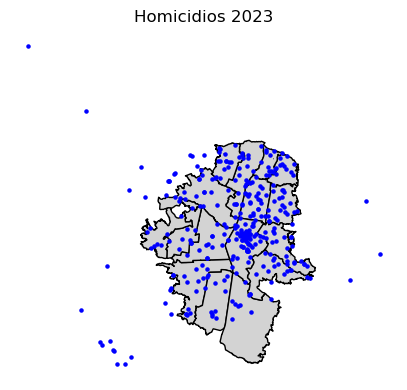

In [123]:
plot_simple(homicidios, 'Homicidios 2023')

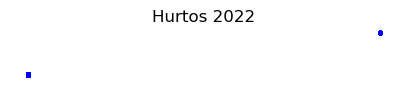

In [124]:
plot_simple(hurtos, 'Hurtos 2022')

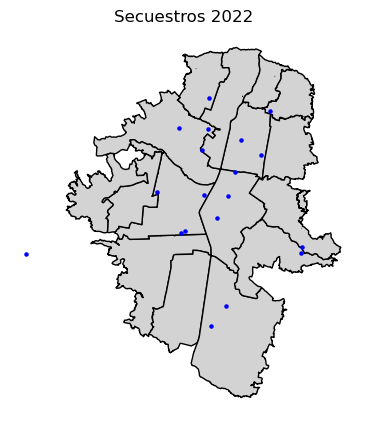

In [125]:
plot_simple(secuestros, 'Secuestros 2022')

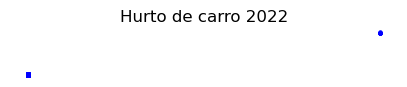

In [126]:
plot_simple(hurto_carro, 'Hurto de carro 2022')

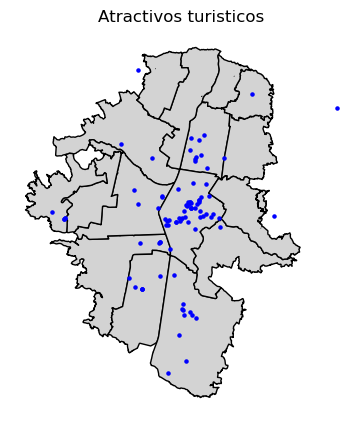

In [127]:
plot_simple(atractivos_turisticos, 'Atractivos turisticos')

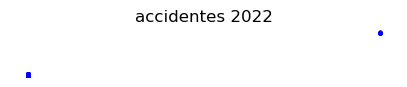

In [128]:
plot_simple(accidentes, 'accidentes 2022')

In [129]:
def comunalizar(gdf, group_name='comuna', agg_name='count'):
    by_district = gpd.sjoin(gdf, gdf_comunas, how="inner", predicate="within")
    return by_district.groupby(group_name).size().reset_index(name=agg_name)

In [130]:
def comunalizar_mult(gdf, cols, group_name='comuna', prefix='col_'):
    by_district = gpd.sjoin(gdf, gdf_comunas, how="inner", predicate="within")
    by_district = by_district.groupby(group_name)[cols].mean().reset_index()
    by_district.columns = ['comuna'] + [prefix + col for col in by_district.columns.difference(['comuna'])]
    return by_district

In [131]:
gdf_hoteles_com = comunalizar_mult(gdf_hoteles, gdf_hoteles.columns.difference(['geometry']), prefix='Turista_')
gdf_residentes_com = comunalizar_mult(gdf_residentes, gdf_residentes.columns.difference(['geometry']), prefix='Residente_')

In [132]:
homicidios_com = comunalizar(homicidios)
secuestros_com = comunalizar(secuestros)
hurtos_com = comunalizar(hurtos)
hurtos_carro_com = comunalizar(hurto_carro)
atractivos_com = comunalizar(atractivos_turisticos)
accidentes_com = comunalizar(accidentes)

In [133]:
def append_comuna(df, init_gdf=gdf_comunas, name='x', nombre='comuna'):
    return init_gdf.merge(df.rename(columns={'count': f'{name}_count'}), on=nombre, how='left').fillna(0)

In [134]:
gdf_summary = append_comuna(homicidios_com, name='homicidios')
gdf_summary = append_comuna(secuestros_com, init_gdf=gdf_summary, name='secuestros')
gdf_summary = append_comuna(hurtos_com, init_gdf=gdf_summary, name='hurtos')
gdf_summary = append_comuna(hurtos_carro_com, init_gdf=gdf_summary, name='hurto_carro')
gdf_summary = append_comuna(atractivos_com, init_gdf=gdf_summary, name='atractivos_turisticos')
gdf_summary = append_comuna(accidentes_com, init_gdf=gdf_summary, name='accidentes')

In [135]:
gdf_summary = gdf_summary.merge(gdf_hoteles_com, on='comuna', how='left')
gdf_summary = gdf_summary.merge(gdf_residentes_com, on='comuna', how='left')

In [136]:
gdf_estrato = gpd.read_file('./DATA/DATASETS/geojson_estrato_socioeconomico/estrato_socioeconomico.geojson', crs=CRS("WGS84"))

/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GeoJSON does not support open option CRS
  return ogr_read(


In [137]:
# gdf_summary_count_cols = list(filter(lambda name: '_Count' in name, gdf_summary.columns))
# gdf_summary[gdf_summary_count_cols] = gdf_summary[gdf_summary_count_cols].fillna(0)

(np.float64(4708228.085545),
 np.float64(4721310.212955),
 np.float64(2240329.785610002),
 np.float64(2257015.617189999))

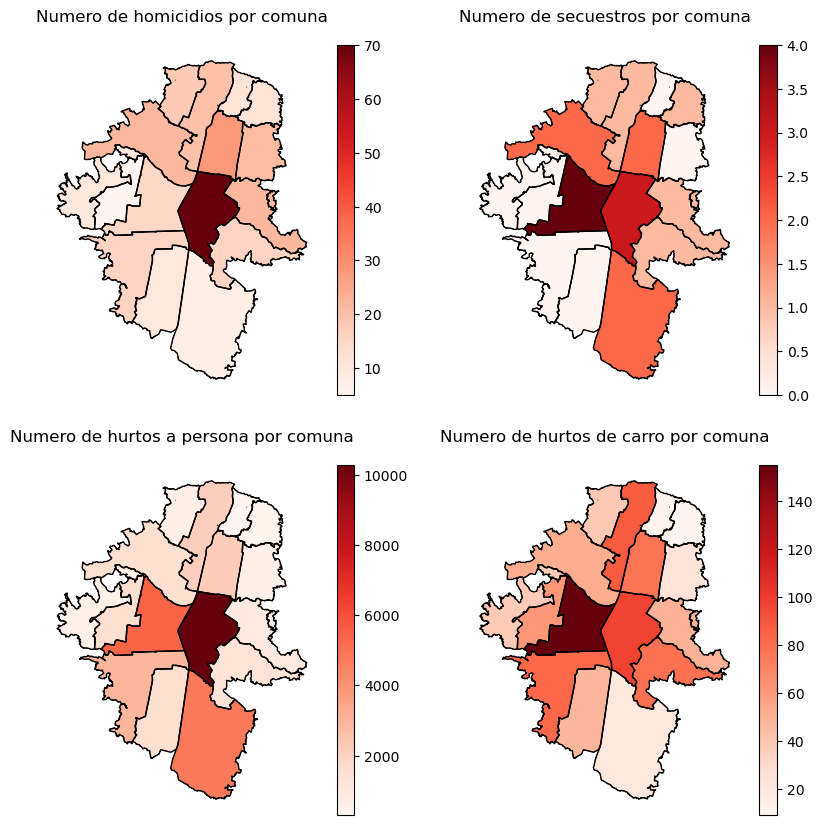

In [138]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

ax1, ax2, ax3, ax4 = axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]
# Set titles for each subplot
ax1.set_title("Numero de homicidios por comuna")
ax2.set_title("Numero de secuestros por comuna")
ax3.set_title("Numero de hurtos a persona por comuna")
ax4.set_title("Numero de hurtos de carro por comuna")
# ax4.set_title("Estrato mediano por comuna")

plot_geodf(gdf_summary, 'homicidios_count', ax1)
plot_geodf(gdf_summary, 'secuestros_count', ax2)
plot_geodf(gdf_summary, 'hurtos_count', ax3)
plot_geodf(gdf_summary, 'hurto_carro_count', ax4)

# gdf_summary.merge(gdf_estrato.groupby('comuna', as_index=False).agg(estrato=('estrato','median'))).plot(column="estrato", linewidth=0.8, edgecolor="black", legend=True, ax=ax4)
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

(np.float64(4708228.085545),
 np.float64(4721310.212955),
 np.float64(2240329.785610002),
 np.float64(2257015.617189999))

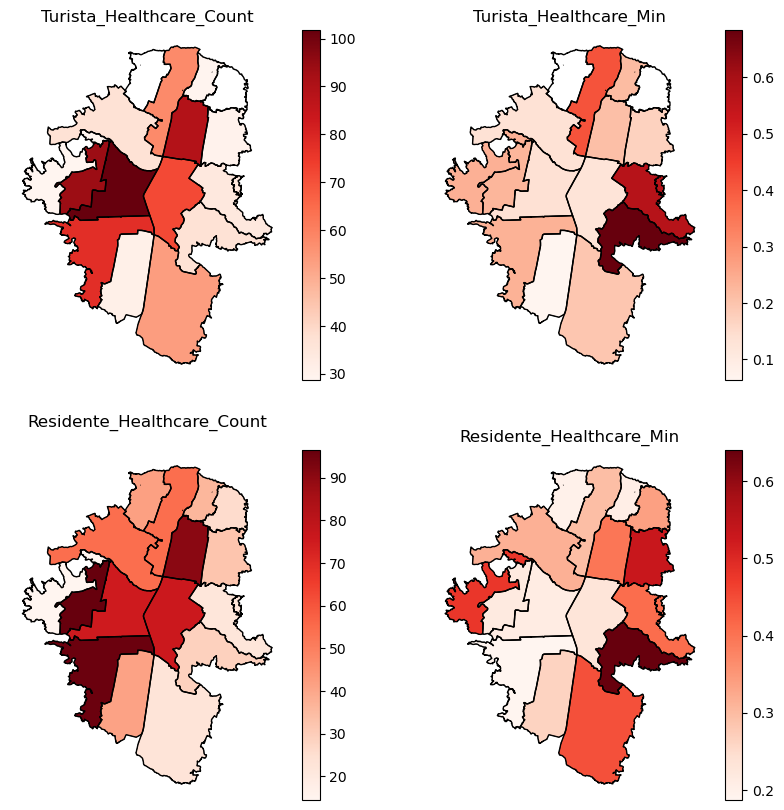

In [139]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

ax1, ax2, ax3, ax4 = axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]
# Set titles for each subplot
ax1.set_title("Turista_Healthcare_Count")
ax2.set_title("Turista_Healthcare_Min")
ax3.set_title("Residente_Healthcare_Count")
ax4.set_title("Residente_Healthcare_Min")
# ax4.set_title("Estrato mediano por comuna")

plot_geodf(gdf_summary, 'Turista_Healthcare_Count', ax1)
plot_geodf(gdf_summary, 'Turista_Healthcare_Min', ax2)
plot_geodf(gdf_summary, 'Residente_Healthcare_Count', ax3)
plot_geodf(gdf_summary, 'Residente_Healthcare_Min', ax4)

# gdf_summary.merge(gdf_estrato.groupby('comuna', as_index=False).agg(estrato=('estrato','median'))).plot(column="estrato", linewidth=0.8, edgecolor="black", legend=True, ax=ax4)
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

In [140]:
estratos = gdf_summary.merge(gdf_estrato.groupby('comuna', as_index=False).agg(estrato=('estrato','median')).rename(columns={'comuna':'corregimiento'}), left_on='comuna', right_on='corregimiento')
# estratos = gdf_summary.merge(gdf_estrato.groupby('comuna', as_index=False).agg(estrato=('estrato','median')).rename(columns={'comuna':'corregimiento'}), left_on='limitecomunacorregimientoid', right_on='corregimiento')

In [141]:
estratos[['homicidios_count', 'secuestros_count', 'hurtos_count', 'hurto_carro_count', 'estrato', 'atractivos_turisticos_count']].corr()

homicidios_count  secuestros_count  hurtos_count  \
homicidios_count                     1.000000          0.487257      0.723278   
secuestros_count                     0.487257          1.000000      0.707114   
hurtos_count                         0.723278          0.707114      1.000000   
hurto_carro_count                    0.341146          0.627803      0.576062   
estrato                             -0.143349          0.406643      0.529825   
atractivos_turisticos_count          0.853627          0.497225      0.892905   

                             hurto_carro_count   estrato  \
homicidios_count                      0.341146 -0.143349   
secuestros_count                      0.627803  0.406643   
hurtos_count                          0.576062  0.529825   
hurto_carro_count                     1.000000  0.416672   
estrato                               0.416672  1.000000   
atractivos_turisticos_count           0.299598  0.201170   

                             atractivos_turisticos_count  
homicidios_count                                0.853627  
secuestros_count                                0.497225  
hurtos_count                                    0.892905  
hurto_carro_count                               0.299598  
estrato                                         0.201170  
atractivos_turisticos_count                     1.000000

In [142]:
correlation = estratos["homicidios_count"].corr(estratos["estrato"], method="pearson")
print(f"Correlacion entre numero de homicidios y estrato socioeconomico: {correlation}")

Correlacion entre numero de homicidios y estrato socioeconomico: -0.14334949492086205


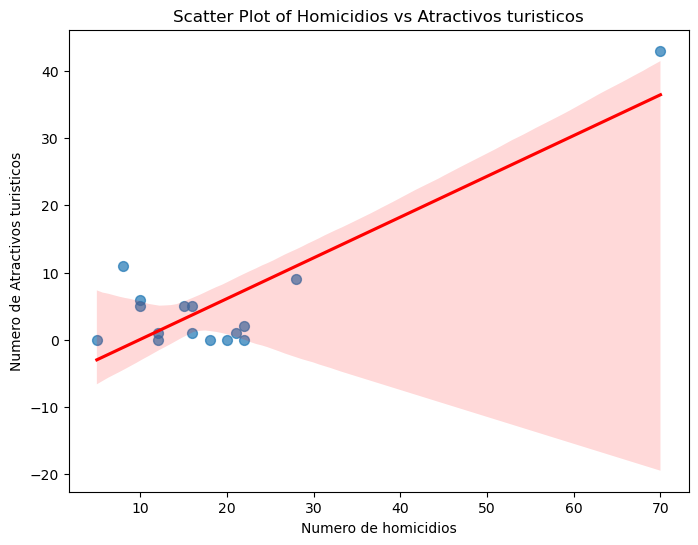

In [143]:
# Scatter plot with a regression line
plt.figure(figsize=(8, 6))
sns.regplot(
    data=estratos,
    x="homicidios_count",
    y="atractivos_turisticos_count",
    scatter_kws={"s": 50, "alpha": 0.7},
    line_kws={"color": "red"}
)
plt.title("Scatter Plot of Homicidios vs Atractivos turisticos")
plt.xlabel("Numero de homicidios")
plt.ylabel("Numero de Atractivos turisticos")
plt.show()

(np.float64(4708228.085545),
 np.float64(4721310.212955),
 np.float64(2240329.785610002),
 np.float64(2257015.617189999))

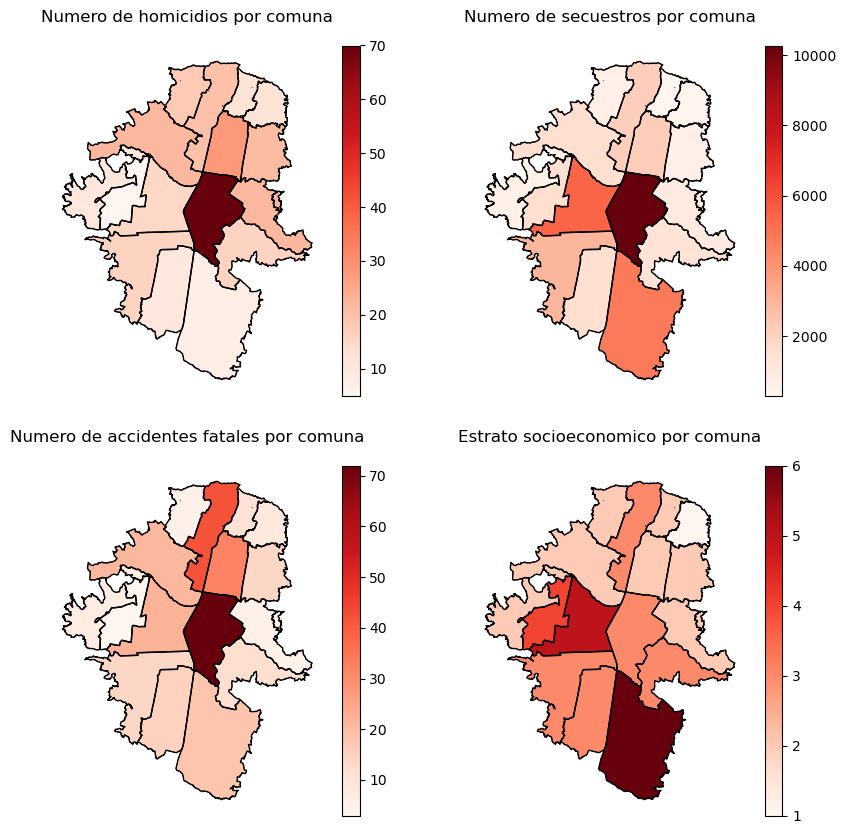

In [144]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

ax1, ax2, ax3, ax4 = axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]
# Set titles for each subplot
ax1.set_title("Numero de homicidios por comuna")
ax2.set_title("Numero de secuestros por comuna")
ax3.set_title("Numero de accidentes fatales por comuna")
ax4.set_title("Estrato socioeconomico por comuna")
# ax4.set_title("Estrato mediano por comuna")

plot_geodf(estratos, 'homicidios_count', ax1)
plot_geodf(estratos, 'hurtos_count', ax2)
plot_geodf(estratos, 'accidentes_count', ax3)
plot_geodf(estratos, 'estrato', ax4)


# gdf_summary.merge(gdf_estrato.groupby('comuna', as_index=False).agg(estrato=('estrato','median'))).plot(column="estrato", linewidth=0.8, edgecolor="black", legend=True, ax=ax4)
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

In [145]:
estratos[['homicidios_count', 'secuestros_count', 'hurtos_count', 'hurto_carro_count', 'accidentes_count', 'estrato']].corr()

homicidios_count  secuestros_count  hurtos_count  \
homicidios_count           1.000000          0.487257      0.723278   
secuestros_count           0.487257          1.000000      0.707114   
hurtos_count               0.723278          0.707114      1.000000   
hurto_carro_count          0.341146          0.627803      0.576062   
accidentes_count           0.855749          0.566327      0.805589   
estrato                   -0.143349          0.406643      0.529825   

                   hurto_carro_count  accidentes_count   estrato  
homicidios_count            0.341146          0.855749 -0.143349  
secuestros_count            0.627803          0.566327  0.406643  
hurtos_count                0.576062          0.805589  0.529825  
hurto_carro_count           1.000000          0.477271  0.416672  
accidentes_count            0.477271          1.000000  0.138317  
estrato                     0.416672          0.138317  1.000000

In [146]:
labels  = {
    "homicidios_count": "Number of homicides",
    "secuestros_count": "Number of kidnappings",
    "hurtos_count": "Number of pickpocketing incidents",
    "hurto_carro_count": "Number of car thefts",
    "atractivos_turisticos_count": "Number of tourist attractions",
    "accidentes_count": "Number of fatal accidents",
    "Turista_CultureAndTourism_Count": "Number of cultural and tourist attractions near a hotel",
    "Turista_CultureAndTourism_Min": "The closest cultural and tourist attraction to the hotel",
    "Turista_Education_Count": "Number of educational institutions near a hotel",
    "Turista_Education_Min": "The closest educational institution to the hotel",
    "Turista_FoodOnly_Count": "Number of food-related attractions near a hotel",
    "Turista_FoodOnly_Min": "The closest food-related attraction to the hotel",
    "Turista_Healthcare_Count": "Number of healthcare facilities near a hotel",
    "Turista_Healthcare_Min": "The closest healthcare facility to the hotel",
    "Turista_Public_transport_Count": "Number of public transport options near a hotel",
    "Turista_Public_transport_Min": "The closest public transport option to the hotel",
    "Turista_Security_Count": "Number of security-related places near a hotel",
    "Turista_Security_Min": "The closest security-related place to the hotel",
    "Turista_ServicesAndGovernment_Count": "Number of service and government institutions near a hotel",
    "Turista_ServicesAndGovernment_Min": "The closest service or government institution to the hotel",
    "Turista_ShopsAndFood_Count": "Number of shops and food-related places near a hotel",
    "Turista_ShopsAndFood_Min": "The closest shop or food-related place to the hotel",
    "Residente_CultureAndTourism_Count": "Number of cultural and tourist attractions near a residence",
    "Residente_CultureAndTourism_Min": "The closest cultural and tourist attraction to the residence",
    "Residente_Education_Count": "Number of educational institutions near a residence",
    "Residente_Education_Min": "The closest educational institution to the residence",
    "Residente_FoodOnly_Count": "Number of food-related attractions near a residence",
    "Residente_FoodOnly_Min": "The closest food-related attraction to the residence",
    "Residente_Healthcare_Count": "Number of healthcare facilities near a residence",
    "Residente_Healthcare_Min": "The closest healthcare facility to the residence",
    "Residente_Public_transport_Count": "Number of public transport options near a residence",
    "Residente_Public_transport_Min": "The closest public transport option to the residence",
    "Residente_Security_Count": "Number of security-related places near a residence",
    "Residente_Security_Min": "The closest security-related place to the residence",
    "Residente_ServicesAndGovernment_Count": "Number of service and government institutions near a residence",
    "Residente_ServicesAndGovernment_Min": "The closest service or government institution to the residence",
    "Residente_ShopsAndFood_Count": "Number of shops and food-related places near a residence",
    "Residente_ShopsAndFood_Min": "The closest shop or food-related place to the residence",
    'estrato': "Stratum of communes"
}

escala  = {
    "homicidios_count": "[Count]",
    "secuestros_count": "[Count]",
    "hurtos_count": "[Count]",
    "hurto_carro_count": "[Count]",
    "atractivos_turisticos_count": "[Count]",
    "accidentes_count": "[Count]",
    "Turista_CultureAndTourism_Count": "[Count]",
    "Turista_CultureAndTourism_Min": "[Average distance Km]",
    "Turista_Education_Count": "[Count]",
    "Turista_Education_Min": "[Average distance Km]",
    "Turista_FoodOnly_Count": "[Count]",
    "Turista_FoodOnly_Min": "[Average distance Km]",
    "Turista_Healthcare_Count": "[Count]",
    "Turista_Healthcare_Min": "[Average distance Km]",
    "Turista_Public_transport_Count": "[Count]",
    "Turista_Public_transport_Min": "[Average distance Km]",
    "Turista_Security_Count": "[Count]",
    "Turista_Security_Min": "[Average distance Km]",
    "Turista_ServicesAndGovernment_Count": "[Count]",
    "Turista_ServicesAndGovernment_Min": "[Average distance Km]",
    "Turista_ShopsAndFood_Count": "[Count]",
    "Turista_ShopsAndFood_Min": "[Average distance Km]",
    "Residente_CultureAndTourism_Count": "[Count]",
    "Residente_CultureAndTourism_Min": "[Average distance Km]",
    "Residente_Education_Count": "[Count]",
    "Residente_Education_Min": "[Average distance Km]",
    "Residente_FoodOnly_Count": "[Count]",
    "Residente_FoodOnly_Min": "[Average distance Km]",
    "Residente_Healthcare_Count": "[Count]",
    "Residente_Healthcare_Min": "[Average distance Km]",
    "Residente_Public_transport_Count": "[Count]",
    "Residente_Public_transport_Min": "[Average distance Km]",
    "Residente_Security_Count": "[Count]",
    "Residente_Security_Min": "[Average distance Km]",
    "Residente_ServicesAndGovernment_Count": "[Count]",
    "Residente_ServicesAndGovernment_Min": "[Average distance Km]",
    "Residente_ShopsAndFood_Count": "[Count]",
    "Residente_ShopsAndFood_Min": "[Average distance Km]",
    'estrato': "[Socioeconomic stratum]"
}

In [147]:
encuesta = pd.read_csv('./DATA/DATASETS/indice_multidimensional_encuesta_calidad_de_vida.csv')

In [148]:
encuesta['intaño'].unique()

array([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])

In [149]:
encuesta['corregimiento'] = encuesta['varcharidcomunafk'].astype(str).str.zfill(2)

In [150]:
estratos[['homicidios_count', 'secuestros_count', 'hurtos_count', 'hurto_carro_count', 'accidentes_count', 'estrato']].corr()

homicidios_count  secuestros_count  hurtos_count  \
homicidios_count           1.000000          0.487257      0.723278   
secuestros_count           0.487257          1.000000      0.707114   
hurtos_count               0.723278          0.707114      1.000000   
hurto_carro_count          0.341146          0.627803      0.576062   
accidentes_count           0.855749          0.566327      0.805589   
estrato                   -0.143349          0.406643      0.529825   

                   hurto_carro_count  accidentes_count   estrato  
homicidios_count            0.341146          0.855749 -0.143349  
secuestros_count            0.627803          0.566327  0.406643  
hurtos_count                0.576062          0.805589  0.529825  
hurto_carro_count           1.000000          0.477271  0.416672  
accidentes_count            0.477271          1.000000  0.138317  
estrato                     0.416672          0.138317  1.000000

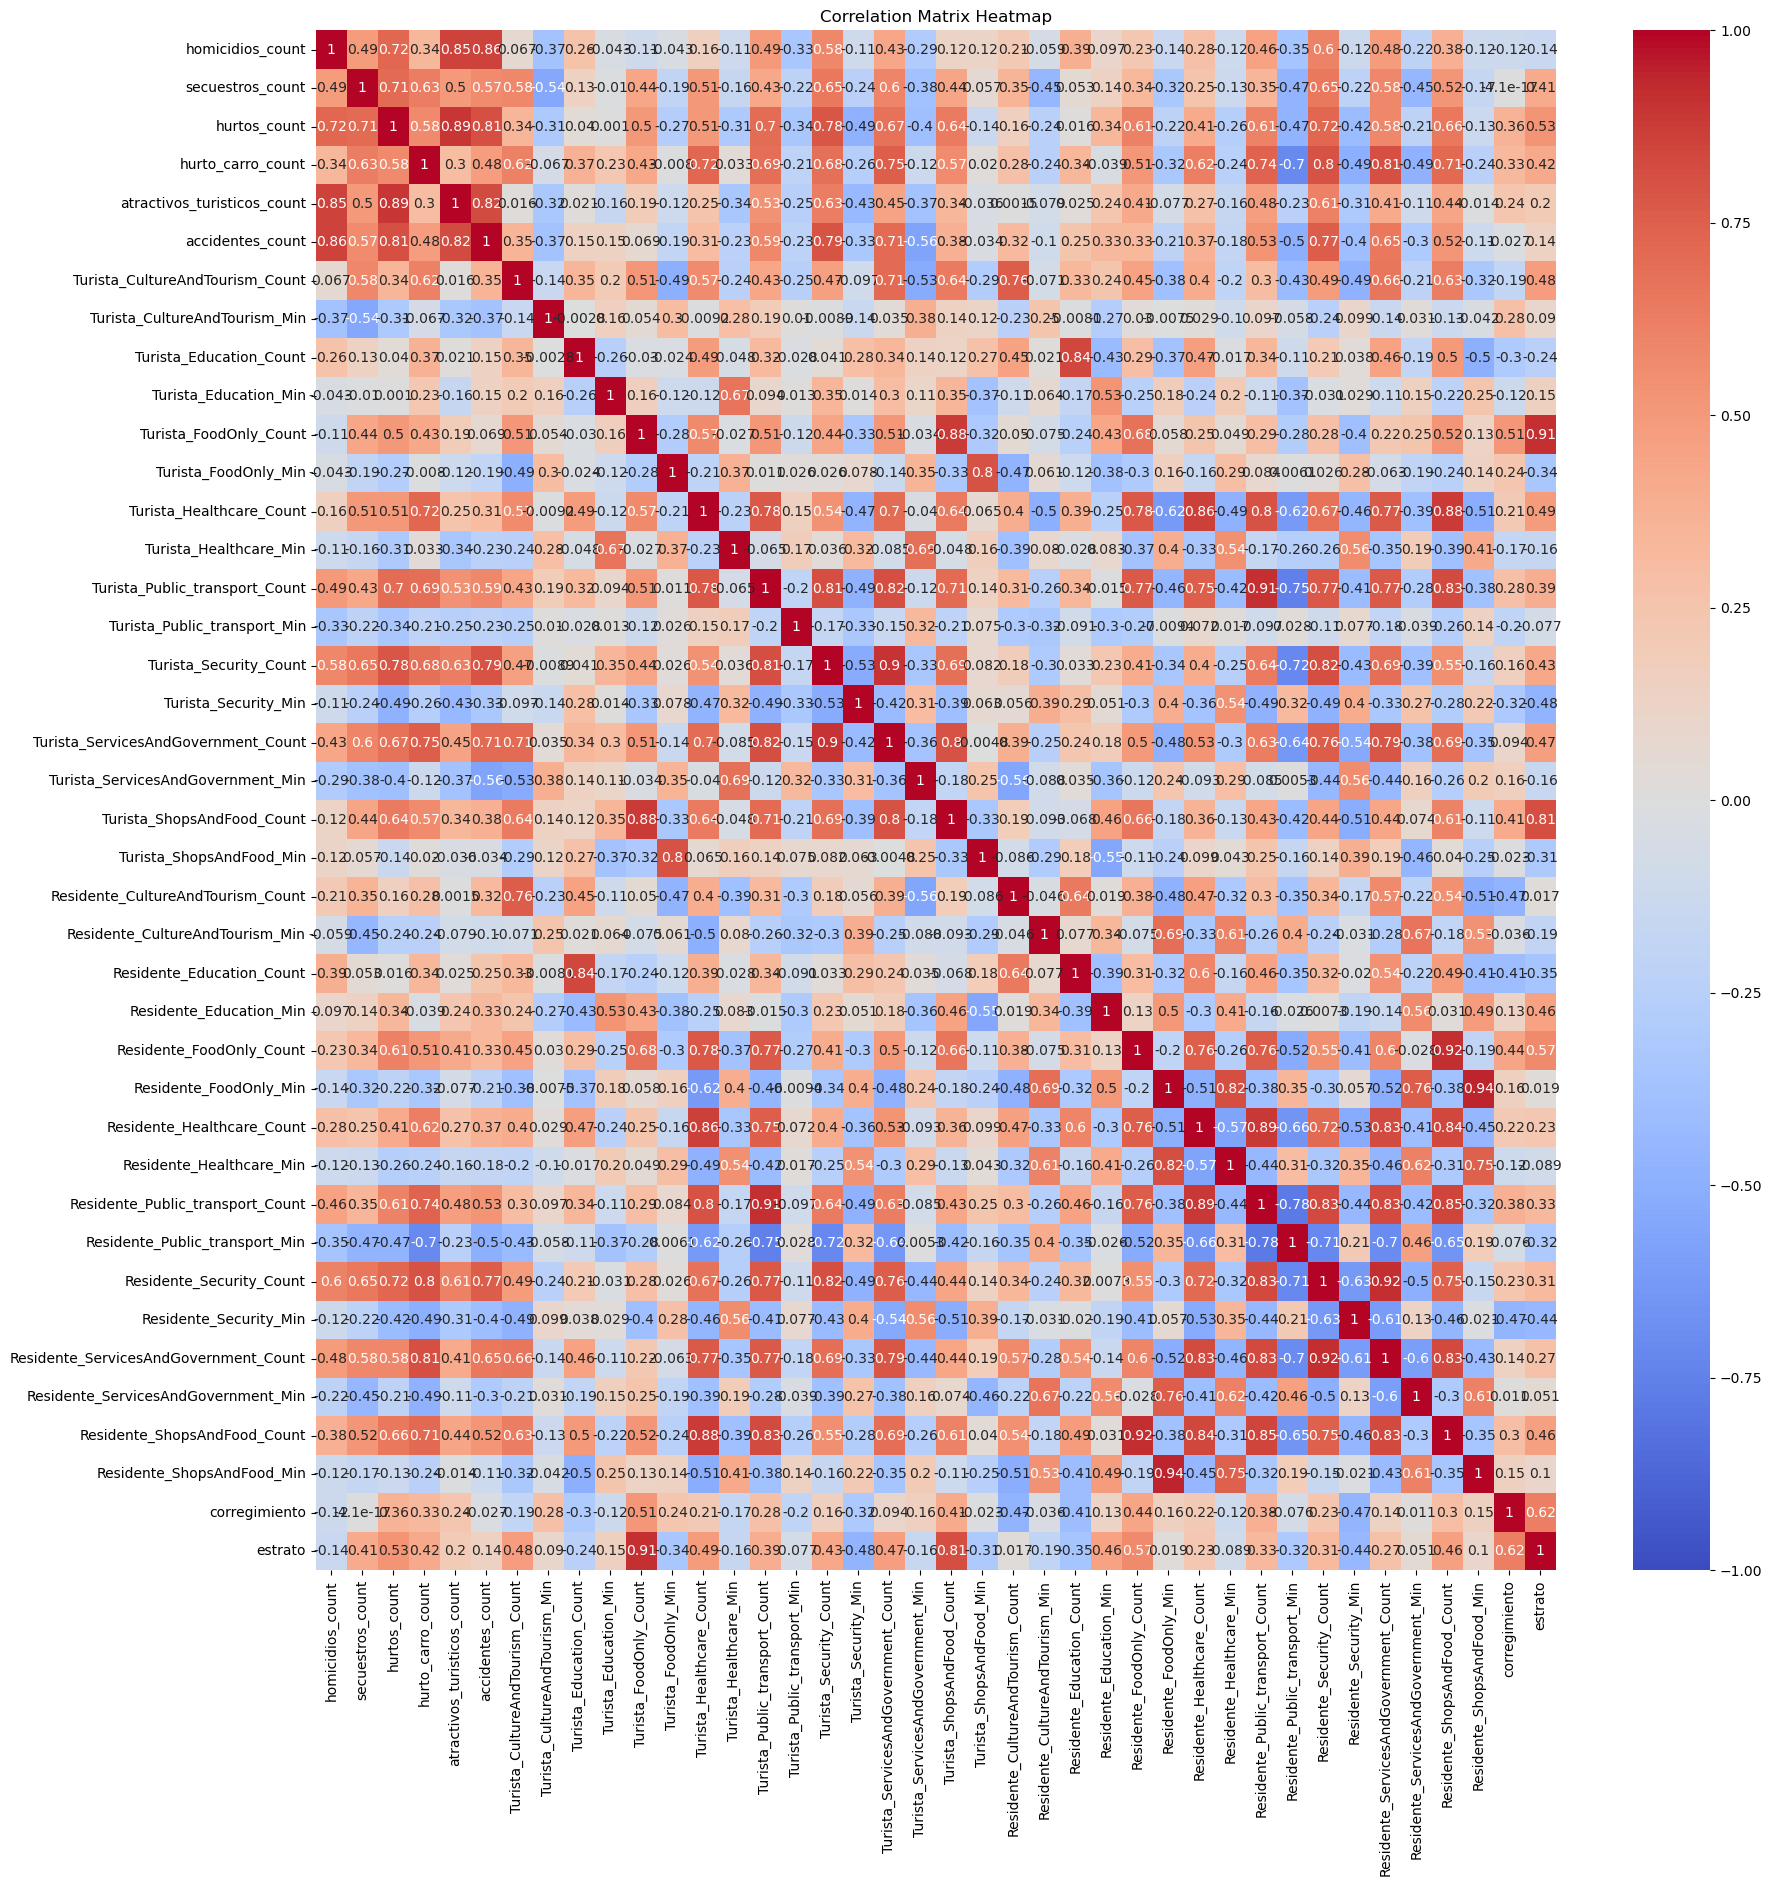

In [151]:
corr_matrix = estratos.drop(['OBJECTID', 'comuna', 'sector', 'nombre', 'identificacion', 'limitecomunacorregimientoid', 'limitemunicipioid', 'subtipo_barriovereda', 'fecha_sincronizacion','Shape_Length', 'Shape_Area', 'geometry', 'intaño', 'varcharidcomunafk'], axis=1, errors='ignore').corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [152]:
cols = estratos.drop(['OBJECTID', 'comuna', 'sector', 'nombre', 'identificacion', 'limitecomunacorregimientoid', 'limitemunicipioid', 'subtipo_barriovereda', 'fecha_sincronizacion','Shape_Length', 'Shape_Area', 'geometry', 'intaño', 'varcharidcomunafk', 'corregimiento'], axis=1, errors='ignore').columns

In [155]:
clean_dir(f'./outs/visualizacion_comuna')

for col in cols:
    fig, ax = plt.subplots(figsize=(7, 7))

    # Set titles for each subplot
    ax.set_title(f"{labels[col]},\n Aggregation by Medellín communes")
    # ax4.set_title("Estrato mediano por comuna")

    cmap = estratos.plot(column=col, cmap="Reds", linewidth=0.4, edgecolor="black", legend=False, ax=ax)
    gdf_comunas_shape.boundary.plot(linewidth=1, edgecolor="black", ax=ax)
    
    cbar = plt.colorbar(cmap.collections[0], ax=ax, orientation="vertical")
    cbar.set_label(f"{escala[col]}")  # Add custom label for the colorbar

    # gdf_summary.merge(gdf_estrato.groupby('comuna', as_index=False).agg(estrato=('estrato','median'))).plot(column="estrato", linewidth=0.8, edgecolor="black", legend=True, ax=ax4)
    ax.axis('off')
    plt.savefig(f'./outs/visualizacion_comuna/{col}.png')
    plt.close()

In [156]:
df = estratos.copy()  # Ejemplo de nombre de DataFrame

# Crear matriz de pesos espaciales usando vecinos de la Reina
wq = lps.weights.Queen.from_dataframe(df)
wq.transform = 'r'

/tmp/ipykernel_18615/2353463311.py:4: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq = lps.weights.Queen.from_dataframe(df)


In [157]:
variables = cols
moran_results = {}

for var in variables:
    # Crear matriz de pesos espaciales usando vecinos de la Reina
    wq = lps.weights.Queen.from_dataframe(df)
    wq.transform = 'r'
    moran = esda.Moran(df[var], wq)
    moran_results[var] = {"I": moran.I, "p-value": moran.p_norm}

moran_res = pd.DataFrame(moran_results).T.sort_values('p-value', ascending=True)

/tmp/ipykernel_18615/2507257913.py:6: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq = lps.weights.Queen.from_dataframe(df)


In [158]:
moran_res[(moran_res['p-value'] <= 0.05) & (abs(moran_res['I']) > 0.2)]

I   p-value
Residente_Security_Min  0.234501  0.046361

In [159]:
bivariate_results = {}

combinaciones = list(itertools.combinations(cols, 2))

# Comparar cada par de variables
for var1, var2 in combinaciones:
    bivariate_moran = esda.Moran_BV(df[var1], df[var2], wq)
    bivariate_results[f"{var1}-{var2}"] = {
        "I": bivariate_moran.I,
        "p-value": bivariate_moran.p_sim
    }

bivariate_results = pd.DataFrame(bivariate_results).T.sort_values('p-value', ascending=True)

In [160]:
bivariate_results[(bivariate_results['p-value'] <= 0.05) & (abs(bivariate_results['I']) > 0.1)].sort_values('I', ascending=False)

I  p-value
Residente_Healthcare_Min-Residente_Security_Min     0.279459    0.024
Residente_CultureAndTourism_Min-Residente_Secur...  0.253748    0.040
Residente_Public_transport_Count-estrato            0.209430    0.020
Residente_Education_Count-Residente_Security_Min    0.186714    0.033
secuestros_count-Residente_FoodOnly_Min             0.140227    0.041
homicidios_count-Residente_Security_Min             0.106763    0.040
hurto_carro_count-Residente_CultureAndTourism_C... -0.180872    0.042
Residente_Education_Count-Residente_Public_tran... -0.199160    0.037
Residente_CultureAndTourism_Count-Residente_Foo... -0.232244    0.018
Residente_Education_Count-Residente_FoodOnly_Count -0.248403    0.008
Residente_Security_Min-estrato                     -0.265556    0.034
Residente_CultureAndTourism_Count-estrato          -0.320500    0.001

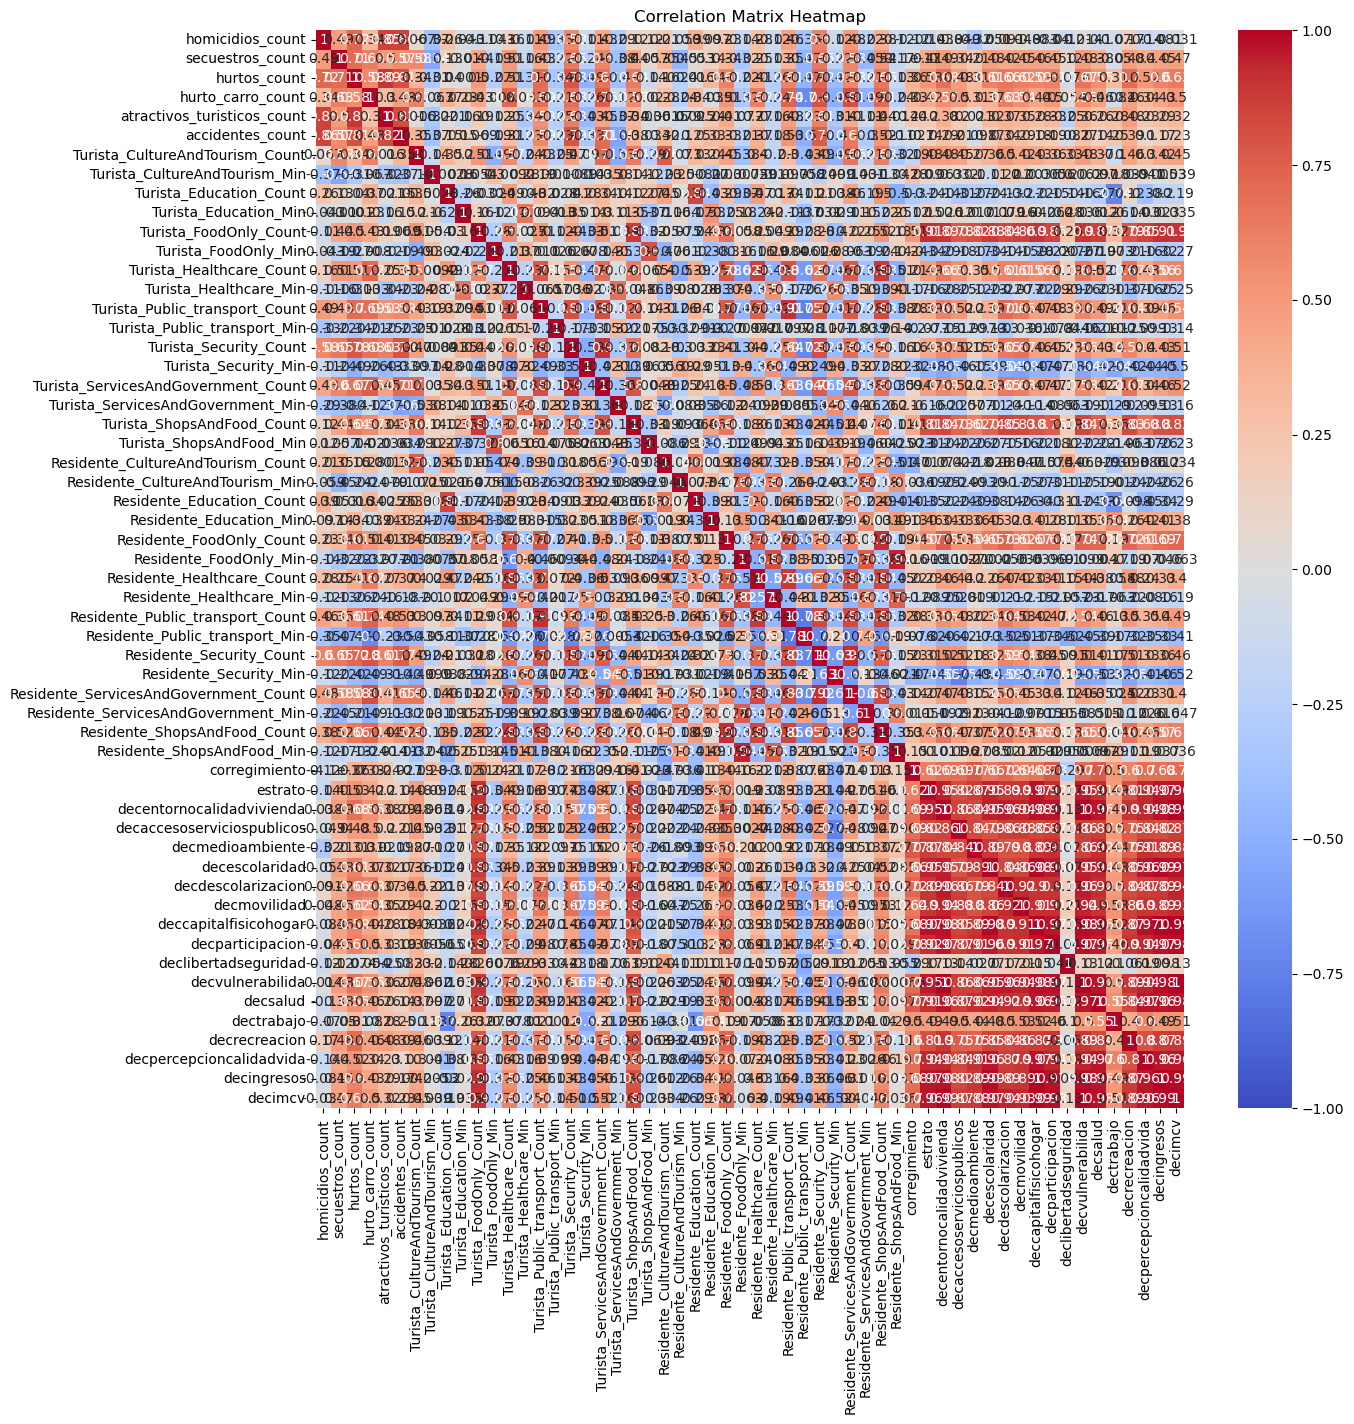

In [161]:
corr_matrix = estratos.merge(encuesta[encuesta['intaño'] == 2018], how='left', on='corregimiento').drop(['OBJECTID', 'comuna', 'sector', 'nombre', 'identificacion', 'limitecomunacorregimientoid', 'limitemunicipioid', 'subtipo_barriovereda', 'fecha_sincronizacion','Shape_Length', 'Shape_Area', 'geometry', 'intaño', 'varcharidcomunafk'], axis=1, errors='ignore').corr()
plt.figure(figsize=(14, 14))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [162]:
from matplotlib.lines import Line2D


In [185]:
def autocorrelacion_espacial(df, col):
    wq =  lps.weights.Queen.from_dataframe(df)
    wq.transform = 'r'
    y = df[col]
    ylag = lps.weights.lag_spatial(wq, y)

    yb = y > y.median()
    labels_ = ["0 Low", "1 High"]
    yb = [labels_[i] for i in 1*yb]
    df['yb'] = yb

    yb = 1 * (y > y.median()) # convert back to binary
    wq =  lps.weights.Queen.from_dataframe(df)
    wq.transform = 'b'
    np.random.seed(12345)
    jc = esda.join_counts.Join_Counts(yb, wq)

    wq.transform = 'r'
    lag_hom = lps.weights.lag_spatial(wq, df[col])

    hom = df[col]
    b, a = np.polyfit(hom, lag_hom, 1)
    f, ax = plt.subplots(1, figsize=(9, 9))

    plt.plot(hom, lag_hom, '.', color='firebrick')

    # dashed vert at mean of the price
    plt.vlines(hom.mean(), lag_hom.min(), lag_hom.max(), linestyle='--')
    # dashed horizontal at mean of lagged price
    plt.hlines(lag_hom.mean(), hom.min(), hom.max(), linestyle='--')

    # red line of best fit using global I as slope
    plt.plot(hom, a + b*hom, 'r')
    plt.title('Moran Scatterplot')
    plt.ylabel(f'Spatial Lag of {col}')
    plt.xlabel(f'{col}')
    plt.savefig(f'./outs/autocorrelacion/scatter_{col}.png')
    plt.close()

    li = esda.moran.Moran_Local(y, wq)

    sig = 1 * (li.p_sim < 0.05)
    hotspot = 1 * (sig * li.q==1)
    coldspot = 3 * (sig * li.q==3)
    doughnut = 2 * (sig * li.q==2)
    diamond = 4 * (sig * li.q==4)
    spots = hotspot + coldspot + doughnut + diamond
    
    spot_labels_text = ['No Spatial Autocorrelation', 'High values surrounded by high values (cluster)', 'Low value surrounded by high values', 'Low values surrounded by low values (cluster)', 'High surrounded by low or vice versa']
    spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
    labels_graph = [spot_labels[i] for i in spots]
    colorset = []
    label_set = []
    colorlist = ['lightgrey', 'red', 'pink', 'blue', 'lightblue']
    for i in range(5):
        if i in spots:
            colorset.append(colorlist[i])
            label_set.append(spot_labels_text[i])
    hmap = colors.ListedColormap(colorset)

    f, ax = plt.subplots(1, figsize=(9, 9))
    df.assign(cl=labels_graph).plot(column='cl', categorical=True, \
            k=2, cmap=hmap, linewidth=0.1, ax=ax, \
            edgecolor='white', legend=False)
    gdf_comunas_shape.boundary.plot(linewidth=1, edgecolor="black", ax=ax)
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colorlist[i], markersize=10, label=spot_labels_text[i]) for i in range(5)]

    # Add the custom legend
    ax.legend(handles=legend_elements, title="Spatial Autocorrelation", bbox_to_anchor=(1.2, 0.1), loc='upper right')
    

    plt.title(f'Spatial Autocorrelation Analysis: {labels[col]},\n Aggregation by Medellín communes')
    ax.set_axis_off()
    plt.savefig(f'./outs/autocorrelacion_comuna/corr_{col}.png')
    plt.close()

In [186]:
clean_dir(f'./outs/autocorrelacion_comuna')

variables_cand = moran_res[(moran_res['p-value'] <= 0.05) & (abs(moran_res['I']) > 0.2)].reset_index()
for variable in variables_cand.iterrows():
    name = variable[1]['index']
    autocorrelacion_espacial(estratos, name)

/tmp/ipykernel_18615/1201860303.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq =  lps.weights.Queen.from_dataframe(df)
/tmp/ipykernel_18615/1201860303.py:13: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq =  lps.weights.Queen.from_dataframe(df)


In [197]:
def autocorrelacion_bivariada(df, col1, col2):
    # Definir la matriz de pesos espaciales (vecindad de reina)
    wq = lps.weights.Queen.from_dataframe(df)
    wq.transform = 'r'

    # Definir las dos variables a correlacionar
    y = df[col1]  # Variable objetivo
    x = df[col2]  # Variable secundaria

    # Calcular Moran Bivariado
    moran_bv = Moran_BV(y, x, wq)
    print(f"Índice de Moran Bivariado: {moran_bv.I}, p-value: {moran_bv.p_sim}")
    # Calcular Moran Local Bivariado
    local_bv = Moran_Local_BV(y, x, wq)

    # Determinar significancia
    sig = 1 * (local_bv.p_sim < 0.05)

    # Identificar hotspots, coldspots y otras categorías de autocorrelación espacial
    hotspot = 1 * (sig * local_bv.q==1)
    coldspot = 3 * (sig * local_bv.q==3)
    doughnut = 2 * (sig * local_bv.q==2)
    diamond = 4 * (sig * local_bv.q==4)
    spots = hotspot + coldspot + doughnut + diamond

    spot_labels = ['0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
    labels_graph = [spot_labels[i] for i in spots]
    spot_labels_text = ['No Spatial Autocorrelation', 'High values surrounded by high values (cluster)', 'Low value surrounded by high values', 'Low values surrounded by low values (cluster)', 'High surrounded by low or vice versa']
    
    colorset = []
    label_set = []
    colorlist = ['lightgrey', 'red', 'pink', 'blue', 'lightblue']
    for i in range(5):
        if i in spots:
            colorset.append(colorlist[i])
            label_set.append(spot_labels_text[i])

    # Crear un mapa de colores para los tipos de correlación espacial
    hmap = colors.ListedColormap(colorset)

    # Graficar los resultados en un mapa
    f, ax = plt.subplots(1, figsize=(9, 9))
    df.assign(cl=labels_graph).plot(column='cl', categorical=True, k=2, cmap=hmap, linewidth=0.1, ax=ax, edgecolor='white', legend=False)
    gdf_comunas_shape.boundary.plot(linewidth=1, edgecolor="black", ax=ax)
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=colorlist[i], markersize=10, label=spot_labels_text[i]) for i in range(5)]
    ax.legend(handles=legend_elements, title="Spatial Bivariate Autocorrelation", bbox_to_anchor=(1.2, 0.1), loc='upper right')
    
    # Título y configuraciones del gráfico
    plt.title(f'Spatial Bivariate Autocorrelation Analysis:\n{labels[col1]} \nand\n {labels[col2]},\n Aggregation by Medellín communes')
    ax.set_axis_off()
    plt.savefig(f'./outs/bivariado_comuna/corr_{col1}_{col2}.png')
    plt.close()

In [198]:
bivariables = bivariate_results[(bivariate_results['p-value'] <= 0.05) & (abs(bivariate_results['I']) > 0.2)].sort_values('I', ascending=False).reset_index()

In [199]:
clean_dir(f'./outs/bivariado_comuna')

for variable in bivariables.iterrows():
    col1, col2 = variable[1]['index'].split('-')
    autocorrelacion_bivariada(estratos, col1, col2)

/tmp/ipykernel_18615/449919654.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq = lps.weights.Queen.from_dataframe(df)


Índice de Moran Bivariado: 0.2794585008311428, p-value: 0.022


/tmp/ipykernel_18615/449919654.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq = lps.weights.Queen.from_dataframe(df)


Índice de Moran Bivariado: 0.25374800665650876, p-value: 0.034


/tmp/ipykernel_18615/449919654.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq = lps.weights.Queen.from_dataframe(df)


Índice de Moran Bivariado: 0.20942996860656227, p-value: 0.015


/tmp/ipykernel_18615/449919654.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq = lps.weights.Queen.from_dataframe(df)


Índice de Moran Bivariado: -0.23224397722733295, p-value: 0.014


/tmp/ipykernel_18615/449919654.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq = lps.weights.Queen.from_dataframe(df)


Índice de Moran Bivariado: -0.24840290163915438, p-value: 0.011


/tmp/ipykernel_18615/449919654.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq = lps.weights.Queen.from_dataframe(df)


Índice de Moran Bivariado: -0.26555601731596856, p-value: 0.041


/tmp/ipykernel_18615/449919654.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  wq = lps.weights.Queen.from_dataframe(df)


Índice de Moran Bivariado: -0.32049988044490163, p-value: 0.001


In [83]:
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu


Test a nivel comunal

In [209]:
test_medias_agg = {}

combinaciones = list(map(lambda x: ['Turista_' + x, 'Residente_' + x],gdf_hoteles.columns.difference(['geometry'])))

# Comparar cada par de variables
for var1, var2 in combinaciones:
    t_stat, p_valueT = ttest_ind(df[var1], df[var2], nan_policy='omit')
    u_stat, p_valueU = mannwhitneyu(df[var1], df[var2], nan_policy='omit')

    test_medias_agg[f"{var1}-{var2}"] = {
        "t_stat": t_stat,
        "p-valueT": p_valueT,
        "u_stat": u_stat,
        "p-valueU": p_valueU,
    }

test_medias_agg = pd.DataFrame(test_medias_agg).T.sort_values('p-valueT', ascending=True)

In [210]:
test_medias_agg = test_medias_agg[(test_medias_agg['p-valueT'] <= 0.05) | (test_medias_agg['p-valueU'] <= 0.05)].reset_index()

In [211]:
test_medias_agg['Turista'] = test_medias_agg['index'].str.split('-').str[0]
test_medias_agg['Residente'] = test_medias_agg['index'].str.split('-').str[1]

In [212]:
test_medias_agg = test_medias_agg[['Turista', 'Residente', 't_stat', 'p-valueT', 'u_stat', 'p-valueU']]

In [213]:
test_medias_agg.to_excel('./outs/test_comuna.xlsx')

Test desagregado

In [214]:
test_medias = {}

combinaciones = list(map(lambda x: [x,x],gdf_hoteles.columns.difference(['geometry'])))

# Comparar cada par de variables
for var1, var2 in combinaciones:
    t_stat, p_valueT = ttest_ind(gdf_hoteles[var1], gdf_residentes[var2], nan_policy='omit')
    u_stat, p_valueU = mannwhitneyu(gdf_hoteles[var1], gdf_residentes[var2], nan_policy='omit')

    test_medias[f"{var1}-{var2}"] = {
        "t_stat": t_stat,
        "p-valueT": p_valueT,
        "u_stat": u_stat,
        "p-valueU": p_valueU,
    }

test_medias = pd.DataFrame(test_medias).T.sort_values('p-valueT', ascending=True)
test_medias

t_stat      p-valueT  \
FoodOnly_Count-FoodOnly_Count                       19.632966  3.152340e-83   
Security_Count-Security_Count                       19.162088  1.742974e-79   
ShopsAndFood_Count-ShopsAndFood_Count               17.951643  3.114220e-70   
ServicesAndGovernment_Count-ServicesAndGovernme...  17.354810  7.195759e-66   
Public_transport_Count-Public_transport_Count       14.066884  3.041618e-44   
Healthcare_Count-Healthcare_Count                   13.012224  3.412885e-38   
CultureAndTourism_Count-CultureAndTourism_Count      9.874073  8.042528e-23   
Security_Min-Security_Min                           -8.418628  4.715097e-17   
Public_transport_Min-Public_transport_Min           -6.784361  1.277800e-11   
ShopsAndFood_Min-ShopsAndFood_Min                   -6.467404  1.075681e-10   
FoodOnly_Min-FoodOnly_Min                           -6.401675  1.653167e-10   
ServicesAndGovernment_Min-ServicesAndGovernment...  -6.131265  9.273013e-10   
Healthcare_Min-Healthcare_Min                       -5.173668  2.369915e-07   
Education_Count-Education_Count                      3.102037  1.930862e-03   
CultureAndTourism_Min-CultureAndTourism_Min         -2.945580  3.235881e-03   
Education_Min-Education_Min                         -2.494378  1.264450e-02   

                                                      u_stat      p-valueU  
FoodOnly_Count-FoodOnly_Count                       918098.0  1.566199e-54  
Security_Count-Security_Count                       911531.0  9.486154e-53  
ShopsAndFood_Count-ShopsAndFood_Count               916236.5  5.398050e-54  
ServicesAndGovernment_Count-ServicesAndGovernme...  891784.0  3.038328e-47  
Public_transport_Count-Public_transport_Count       882792.5  7.518103e-45  
Healthcare_Count-Healthcare_Count                   862379.0  1.063717e-39  
CultureAndTourism_Count-CultureAndTourism_Count     753342.5  1.290845e-17  
Security_Min-Security_Min                           201081.0  1.744119e-50  
Public_transport_Min-Public_transport_Min           307911.0  2.472479e-25  
ShopsAndFood_Min-ShopsAndFood_Min                   266138.0  4.153705e-34  
FoodOnly_Min-FoodOnly_Min                           275679.0  5.526152e-32  
ServicesAndGovernment_Min-ServicesAndGovernment...  319860.0  4.499548e-23  
Healthcare_Min-Healthcare_Min                       251852.0  2.020074e-37  
Education_Count-Education_Count                     610410.5  1.365697e-02  
CultureAndTourism_Min-CultureAndTourism_Min         487290.0  5.546916e-03  
Education_Min-Education_Min                         486777.0  5.186128e-03

In [215]:
test_medias = test_medias[(test_medias['p-valueT'] <= 0.05) | (test_medias['p-valueU'] <= 0.05)].reset_index()
test_medias['Turista'] = test_medias['index'].str.split('-').str[0]
test_medias['Residente'] = test_medias['index'].str.split('-').str[1]
test_medias = test_medias[['Turista', 'Residente', 't_stat', 'p-valueT', 'u_stat', 'p-valueU']]

In [216]:
test_medias.to_excel('./outs/test_desagregado.xlsx')